### Characterzing the problem of two magnetic surveys  acquired in different years and thus with different Geomagnetic Field - By Valeria CF Barbosa
#### Shayane's Thesis 

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
import cPickle as pickle
import datetime
from IPython.display import Markdown as md
from IPython.display import display as dp
import string as st

from __future__ import division
from future.builtins import super

import auxiliary_functions as af

import fatiando
from fatiando import gridder
from fatiando.mesher import Prism, PointGrid
from fatiando.gridder import regular
from fatiando.gravmag import prism, sphere
from fatiando.gravmag.eqlayer import EQLTotalField
from fatiando.gravmag.eqlayer import EQLGravity
from fatiando.inversion.regularization import Damping, Smoothness2D
from fatiando.inversion.hyper_param import LCurve
from fatiando.vis import mpl, myv
from fatiando.utils import ang2vec, vec2ang, contaminate, dircos
from fatiando.constants import G, SI2MGAL

C:\Users\valeria\Anaconda2\lib\site-packages\fatiando\vis\mpl.py:70: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")
C:\Users\valeria\Anaconda2\lib\site-packages\fatiando\vis\myv.py:53: UserWarning: This module will be removed in v0.7.
  warnings.warn("This module will be removed in v0.7.")


In [2]:
from numpy import linalg
from scipy.optimize import nnls
from scipy.sparse import identity
from scipy.sparse import diags
from scipy.stats import norm



In [3]:
notebook_name = 'Equivalent_Layer_Shayane_Two_Grids_.ipynb'

In [4]:
print("Version of Fatiando a Terra used: {}".format(fatiando.__version__))

Version of Fatiando a Terra used: ac2afbcb2d99b18f145cc1ed40075beb5f92dd5a


# Load the synthetic model formed by one prism

In [5]:
with open('../data/model_single.pickle') as f:
        full_model_single = pickle.load(f)

In [6]:
with open('../data/model_single_pole.pickle') as f:
        full_model_single_pole = pickle.load(f)

### GEOMAGNETIC FILED INFORMATION: Inclination and Declination of two grids

In [7]:
Geomagnetic_Information = dict() #empty dictionary

In [8]:
#Geomagnetic_Information['geomag_field'] = [(60., 10.), (60., 10.)]   # Test with equal Geomagnetic field in both surveys

Geomagnetic_Information['geomag_field'] = [(6., -40.5), (60., 10.)] # Test with DIFFERENT Geomagnetic field in the surveys

print 'Inclination and Declination of the Geomagnetic Field of Grid 1'
print Geomagnetic_Information['geomag_field'][0]
print 'Inclination and Declination of the Geomagnetic Field of Grid 2'
print Geomagnetic_Information['geomag_field'][1]

Inclination and Declination of the Geomagnetic Field of Grid 1
(6.0, -40.5)
Inclination and Declination of the Geomagnetic Field of Grid 2
(60.0, 10.0)


In [9]:
number_geomag_field = len(Geomagnetic_Information['geomag_field'])
print 'Number of Geomagnetic Fields', number_geomag_field

Number of Geomagnetic Fields 2


Geomagnetic_Information['geomag_field_1'] = (6., -40.5)
Geomagnetic_Information['geomag_field_2'] = (60., 10.)

#Geomagnetic_Information['geomag_field_1'] = (60., 10.)
#Geomagnetic_Information['geomag_field_2'] = (60., 10.)

print 'Inclination and Declination of the Geomagnetic Field of Grid 1'
print Geomagnetic_Information['geomag_field_1']
print 'Inclination and Declination of the Geomagnetic Field of Grid 2'
print Geomagnetic_Information['geomag_field_2']

### Magnetic vector of the siurce

In [10]:
ints, incs, decs = vec2ang(full_model_single['model'][0].props['magnetization'])
print 'Intensity, Inclination and Declination of the sources '
print ints, incs, decs

Intensity, Inclination and Declination of the sources 
10.0 30.0 -10.0


# Load the grid of points

In [11]:
with open('../data/regular_grid1.pickle') as f:
        regular_grid1 = pickle.load(f)

In [12]:
regular_grid1

{'DS1': 93984.96240601504,
 'N1': 300,
 'area1': [0, 5000, -5000, 0],
 'metadata1': 'Generated by computation_points_two_grids_.ipynb on 29 May 2018 19:41:15 UTC',
 'shape1': (15, 20),
 'spacing1': [357.14285714285717, 263.1578947368421]}

In [13]:
with open('../data/regular_grid2.pickle') as f:
        regular_grid2 = pickle.load(f)

In [14]:
regular_grid2

{'N2': 300,
 'area2': [0, 5000, 0, 5000],
 'metadata2': 'Generated by computation_points_two_grids_.ipynb on 29 May 2018 19:41:15 UTC',
 'shape2': (15, 20),
 'spacing2': [357.14285714285717, 263.1578947368421]}

# Define the coordinates on the observation surface


In [15]:
#coordinates x and y of the data
xp1, yp1 = regular(regular_grid1['area1'], regular_grid1['shape1'])
print len(xp1)

#vertical coordinates of the data 
#zp = af.observation_surface(xp,yp)

# vertical coordinates of the data
zp1 = np.zeros_like(xp1)
height_obs = -50.

print len(zp1)

assert (xp1.size == regular_grid1['N1']) and (yp1.size == regular_grid1['N1']) and (zp1.size == regular_grid1['N1']),  \
                'xp1 and yp1 and zp1 must have the same size defined by shape1'


300
300


In [16]:
#coordinates x and y of the data
xp2, yp2 = regular(regular_grid2['area2'], regular_grid2['shape2'])
print len(xp2)

#vertical coordinates of the data 
#zp = af.observation_surface(xp,yp)

# vertical coordinates of the data
zp2 = np.zeros_like(xp2)
height_obs = -50.

print len(zp2)

assert (xp2.size == regular_grid2['N2']) and (yp2.size == regular_grid2['N2']) and (zp2.size == regular_grid2['N2']),  \
                'xp2 and yp2 and zp2 must have the same size defined by shape2'

300
300


# Noise Free observed total-field anomaly

In [17]:
#tf_noise = 5.
tf_noise = 0.

In [18]:
inc1, dec1 = Geomagnetic_Information['geomag_field'][0]
tf1 = contaminate(prism.tf(xp1,yp1,zp1,full_model_single['model'], inc1, dec1), tf_noise, seed=47)

..\figs\Total_Field1


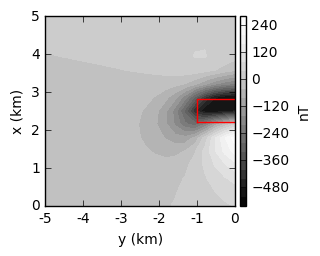

In [19]:
file_name = '..\\figs\\Total_Field1'

print file_name

af.plotmap(xp1, yp1, tf1, regular_grid1['shape1'], regular_grid1['area1'],
                color_scheme = 'Greys_r', prism_projection = True, projection_style = '-r', 
                model = full_model_single['projection'], unit = 'nT')

plt.savefig(file_name+'.eps', dpi=600)
#saved_files.append(file_name+'.eps')

plt.show()

In [20]:
inc2, dec2 = Geomagnetic_Information['geomag_field'][1]
tf2 = contaminate(prism.tf(xp2,yp2,zp2,full_model_single['model'], inc2, dec2), tf_noise, seed=47)

..\figs\Total_Field2


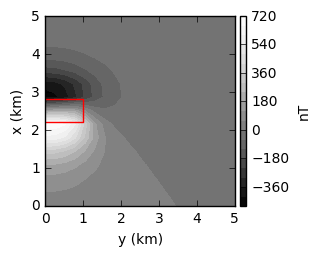

In [21]:
file_name = '..\\figs\\Total_Field2'

print file_name

af.plotmap(xp2, yp2, tf2, regular_grid2['shape2'], regular_grid2['area2'],
                color_scheme = 'Greys_r', prism_projection = True, projection_style = '-r', 
                model = full_model_single['projection'], unit = 'nT')

plt.savefig(file_name+'.eps', dpi=600)
#saved_files.append(file_name+'.eps')

plt.show()

### Joint the coordinates 
#### The new coordinates are: xp yp and zp

In [22]:
xp=np.append(xp1,xp2)
yp=np.append(yp1,yp2)
zp=np.append(zp1,zp2)

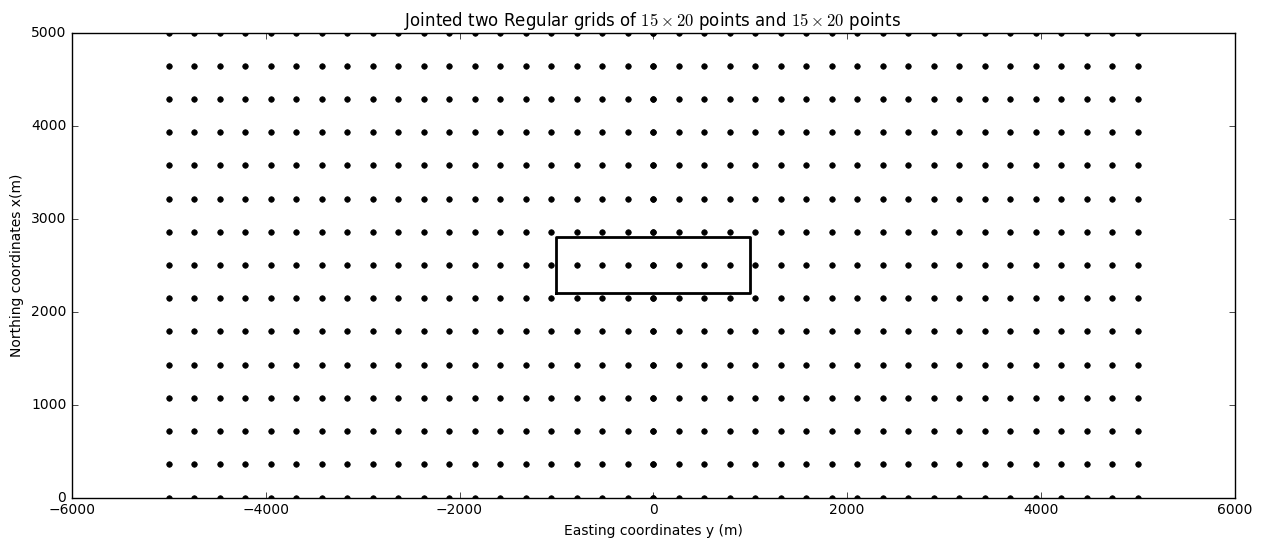

In [23]:
plt.figure(figsize=(15, 6))

ax = plt.gca()
plt.plot(yp, xp, 'k.', markersize=8)

plt.title("Jointed two Regular grids of $%d \\times %d$ points and $%d \\times %d$ points " \
%(regular_grid1['shape1'][0], regular_grid1['shape1'][1], regular_grid2['shape2'][0], regular_grid2['shape2'][1]))


for i, sq in enumerate(full_model_single['projection']):
    y1, y2, x1, x2 = sq
    xs = [x1, x1, x2, x2, x1]
    ys = [y1, y2, y2, y1, y1]
    projection_style = '-k'
    ax.plot(xs, ys, projection_style,linewidth = 2.0 )
    
        
plt.xlabel('Easting coordinates y (m)')
plt.ylabel('Northing coordinates x(m)')


## Joint Data
### The new data is the variable: tf

In [24]:
tf=np.append(tf1,tf2)


print len(tf), len(xp), len(yp)
print min(tf)

600 600 600
-524.316791678


###  Verifying the New Number of the Data given by the length of the variable tf

In [25]:
Npts = len(tf)
print 'number of data: Npts', Npts

assert (xp.size == Npts) and (yp.size == Npts) and (zp.size == Npts),  \
                'xp, yp1 and zp must have the same size defined by Npts'


number of data: Npts 600


### Creating a new area and a new shape to compute a single equivalent layer

In [26]:
a_north_min = min(regular_grid1['area1'][0],regular_grid2['area2'][0])
a_north_max = max(regular_grid1['area1'][1],regular_grid2['area2'][1])
a_east_min = min(regular_grid1['area1'][2],regular_grid2['area2'][2])
a_east_max = max(regular_grid1['area1'][3],regular_grid2['area2'][3])

# New Area
area = [a_north_min, a_north_max, a_east_min, a_east_max]
print 'NEW AREA:', area

# New Shape  (this shape was created manually)
shape = [15,40]

print 'NEW SHAPE:', shape

NEW AREA: [0, 5000, -5000, 5000]
NEW SHAPE: [15, 40]


### Planar equivalent layer

#### Parameters defining the equivalent layer

In [27]:
#horizontal plane containing the equivalent sources located at h 
z0 = np.zeros_like(zp)
h = 400.
z0 += h
print h

400.0


In [28]:
print len(tf), len(xp), len(yp), area, shape

600 600 600 [0, 5000, -5000, 5000] [15, 40]


# Estimated magnetic moment distribution

In [29]:
# creating the layer of the equivalent layer
layer = PointGrid(area, h, shape)

In [30]:
M_source = len(layer)
print 'number of the equivalent sources at the equivalent layer: M_source', M_source

assert (M_source == Npts),'We are imposing that M_source must have the same size defined by Npts'


number of the equivalent sources at the equivalent layer: M_source 600


In [31]:
print 'number of point at the equivalent layers', len(layer)

number of point at the equivalent layers 600


In [32]:
print len(xp), len(tf), inc1, dec1,inc2, dec2, incs, decs

600 600 6.0 -40.5 60.0 10.0 30.0 -10.0


# Sensitivity Matrix (dipoles) via Fatiando 
### By using the inclination and declination of the geomagnetic field of one of the surveys
####  Geomagnetic_Information['geomag_field'][0]   OR Geomagnetic_Information['geomag_field'][1]

In [33]:
# Inclination and declintion of the source
mag = dircos(incs, decs)
print mag

[0.85286853195244328, -0.15038373318043527, 0.49999999999999983]


In [34]:
# By using the inclination and declination of the geomagnetic field of one of the surveys
#  Geomagnetic_Information['geomag_field'][0] or Geomagnetic_Information['geomag_field'][1]

chosen_survey = 1
assert (chosen_survey >= 0) and (chosen_survey <= number_geomag_field),\
              'The chossen survey must be great equal to 0 and less equal to the length of geomagnetic fields'

Inc_Geomag_EqLayer, Dec_Geomag_EqLayer = Geomagnetic_Information['geomag_field'][chosen_survey]

print 'Geomagnetic Filed used in the Equivalent Layer:', Inc_Geomag_EqLayer, Dec_Geomag_EqLayer
print 'Geomagnetic Field chosen was the magnetic survey: ', chosen_survey + 1

Geomagnetic Filed used in the Equivalent Layer: 60.0 10.0
Geomagnetic Field chosen was the magnetic survey:  2


In [35]:
# Sensitivity Matrix from Fatiando
TF_Fatiando = np.empty((Npts,M_source),dtype =float)
for i, c in enumerate(layer):
    TF_Fatiando[:,i] = sphere.tf(xp, yp, zp, [c], Inc_Geomag_EqLayer, Dec_Geomag_EqLayer,pmag=mag)
   

In [36]:
ATA = np.empty((M_source,M_source),dtype =float)
ATA = np.dot(np.transpose(TF_Fatiando),TF_Fatiando)

In [37]:
reg_parameter = 0.0000000000000000000001
#reg_parameter = 0.00000000000000000001

Hessiana  = ATA + diags([reg_parameter], 0, (M_source,M_source), format='csr', dtype='float')

In [38]:
ATdo = np.dot(np.transpose(TF_Fatiando),tf)

In [39]:
p = linalg.solve(Hessiana,ATdo)


In [40]:
tf_predicted    = np.dot(TF_Fatiando,p)
residual        = tf - tf_predicted

In [41]:
print  np.linalg.norm(residual)/Npts


1.21204013763


In [42]:
print shape

[15, 40]


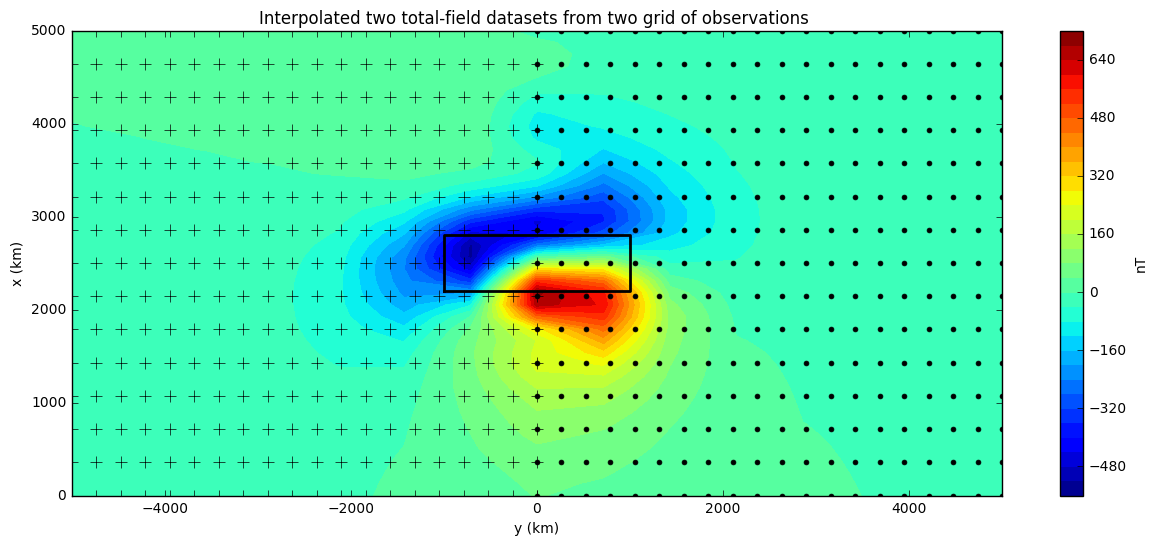

In [43]:
file_name = '..\\figs\\Observed_Total_Field_jointed'

plt.figure(figsize=(15, 6))
unit = 'nT'
mpl.contourf(yp, xp, tf, shape, 40, interp=True)

plt.plot(yp1, xp1, 'k+', markersize=9)
plt.plot(yp2, xp2, 'k.', markersize=7)
cbar = plt.colorbar()
cbar.set_label(unit)
ax = plt.gca()
for i, sq in enumerate(full_model_single['projection']):
    y1, y2, x1, x2 = sq
    xs = [x1, x1, x2, x2, x1]
    ys = [y1, y2, y2, y1, y1]
    projection_style = '-k'
    ax.plot(xs, ys, projection_style,linewidth = 2.0 )
ax.set_ylabel('x (km)')
ax.set_xlabel('y (km)')
ax.set_title('Interpolated two total-field datasets from two grid of observations ')
plt.savefig(file_name+'.eps', dpi=600)

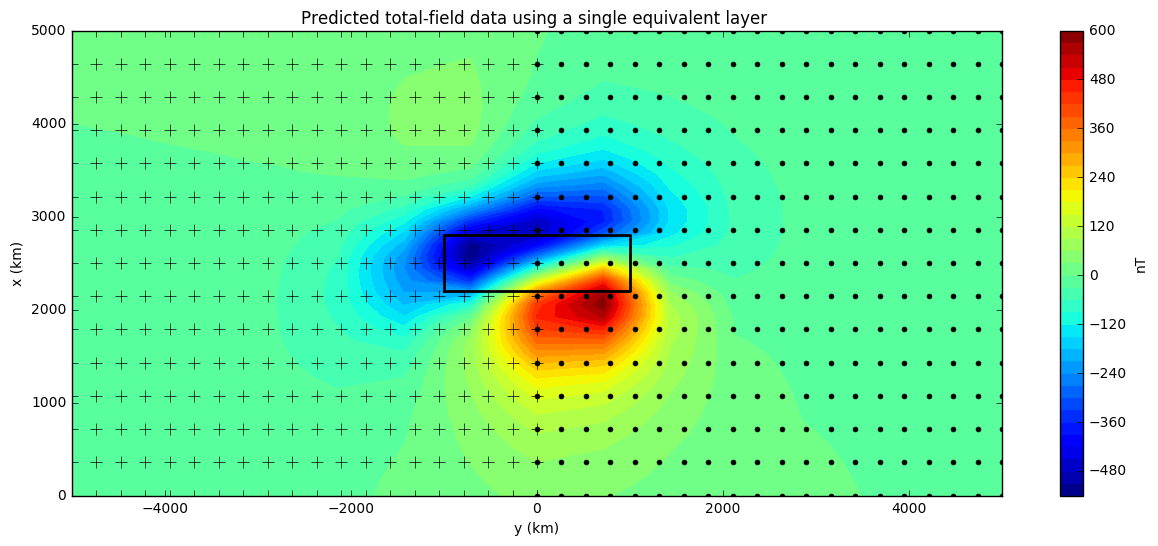

In [44]:
file_name = '..\\figs\\Predicted_Total_Field_jointed'
plt.figure(figsize=(15, 6))
unit = 'nT'
mpl.contourf(yp, xp, tf_predicted, shape, 40, interp=True)

plt.plot(yp1, xp1, 'k+', markersize=9)
plt.plot(yp2, xp2, 'k.', markersize=7)
cbar = plt.colorbar()
cbar.set_label(unit)
ax = plt.gca()
for i, sq in enumerate(full_model_single['projection']):
    y1, y2, x1, x2 = sq
    xs = [x1, x1, x2, x2, x1]
    ys = [y1, y2, y2, y1, y1]
    projection_style = '-k'
    ax.plot(xs, ys, projection_style,linewidth = 2.0 )
ax.set_ylabel('x (km)')
ax.set_xlabel('y (km)')
ax.set_title('Predicted total-field data using a single equivalent layer ')
plt.savefig(file_name+'.eps', dpi=600)

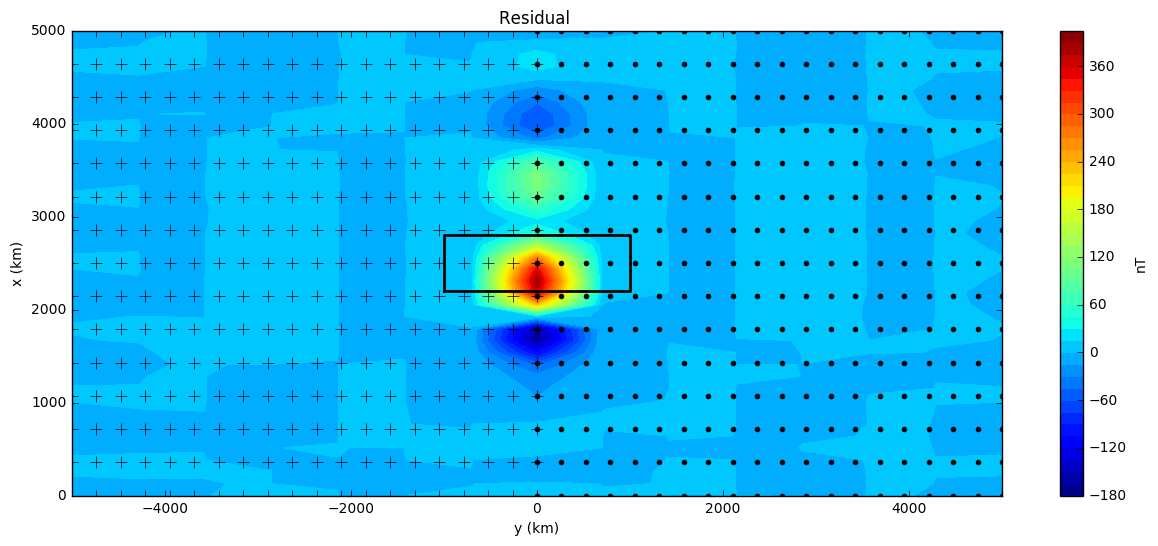

In [45]:
file_name = '..\\figs\\Residual_jointed'
plt.figure(figsize=(15, 6))
unit = 'nT'
mpl.contourf(yp, xp,residual, shape, 40, interp=True)

plt.plot(yp1, xp1, 'k+', markersize=9)
plt.plot(yp2, xp2, 'k.', markersize=7)
cbar = plt.colorbar()
cbar.set_label(unit)
ax = plt.gca()
for i, sq in enumerate(full_model_single['projection']):
    y1, y2, x1, x2 = sq
    xs = [x1, x1, x2, x2, x1]
    ys = [y1, y2, y2, y1, y1]
    projection_style = '-k'
    ax.plot(xs, ys, projection_style,linewidth = 2.0 )
ax.set_ylabel('x (km)')
ax.set_xlabel('y (km)')
ax.set_title('Residual ')

plt.savefig(file_name+'.eps', dpi=600)

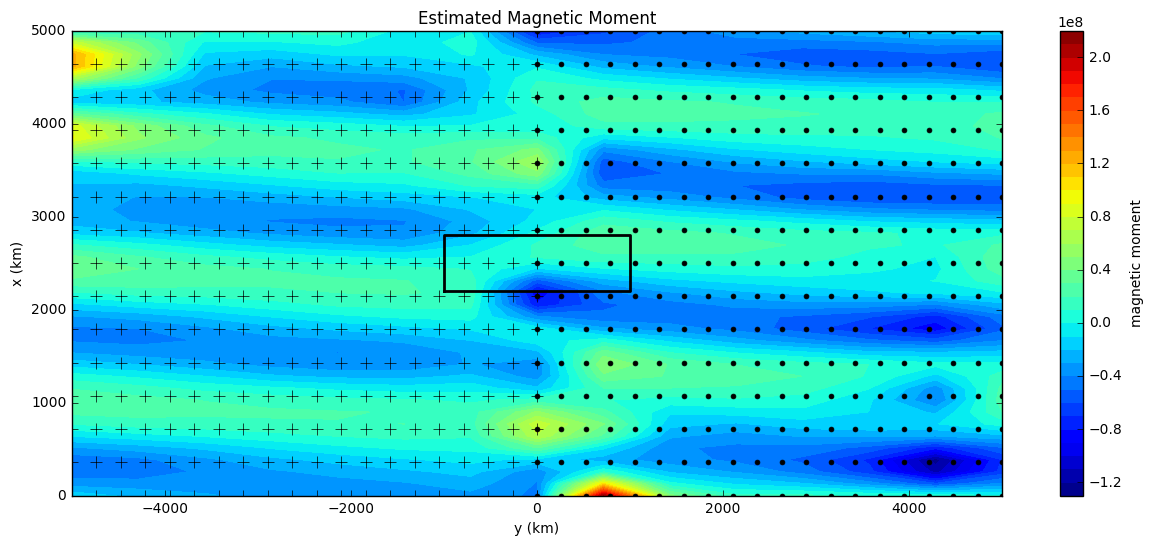

In [46]:
file_name = '..\\figs\\Estimated Magnetic Moment_jointed'
plt.figure(figsize=(15, 6))
unit = 'magnetic moment'
mpl.contourf(yp, xp, p, shape, 40, interp=True)

plt.plot(yp1, xp1, 'k+', markersize=9)
plt.plot(yp2, xp2, 'k.', markersize=7)
cbar = plt.colorbar()
cbar.set_label(unit)
ax = plt.gca()
for i, sq in enumerate(full_model_single['projection']):
    y1, y2, x1, x2 = sq
    xs = [x1, x1, x2, x2, x1]
    ys = [y1, y2, y2, y1, y1]
    projection_style = '-k'
    ax.plot(xs, ys, projection_style,linewidth = 2.0 )
ax.set_ylabel('x (km)')
ax.set_xlabel('y (km)')
ax.set_title('Estimated Magnetic Moment')
plt.savefig(file_name+'.eps', dpi=600)

In [47]:
print max(p), min(p)

343199537.256 -137448619.988


In [48]:
saved_files = [] #list of saved files
file_name = '..\data\geomagnetic_field_two_grids.pickle'
with open(file_name, 'w') as f:
    pickle.dump(Geomagnetic_Information, f)
    
saved_files.append(file_name)

# REDUCTION TO THE POLE

In [49]:
layer_pole = PointGrid(area, h, shape)
layer_pole.addprop('magnetization', ang2vec(p, 90., 0.))

print area, shape, h, len(zp)

#xrtp, yrtp = regular(area, shape)


[0, 5000, -5000, 5000] [15, 40] 400.0 600


In [50]:
print full_model_single['model']

In [51]:
tfpole = prism.tf(xp, yp, zp, full_model_single_pole['model_pole'], 90., 0.)
tfreduced = sphere.tf(xp, yp, zp, layer_pole, 90., 0.)

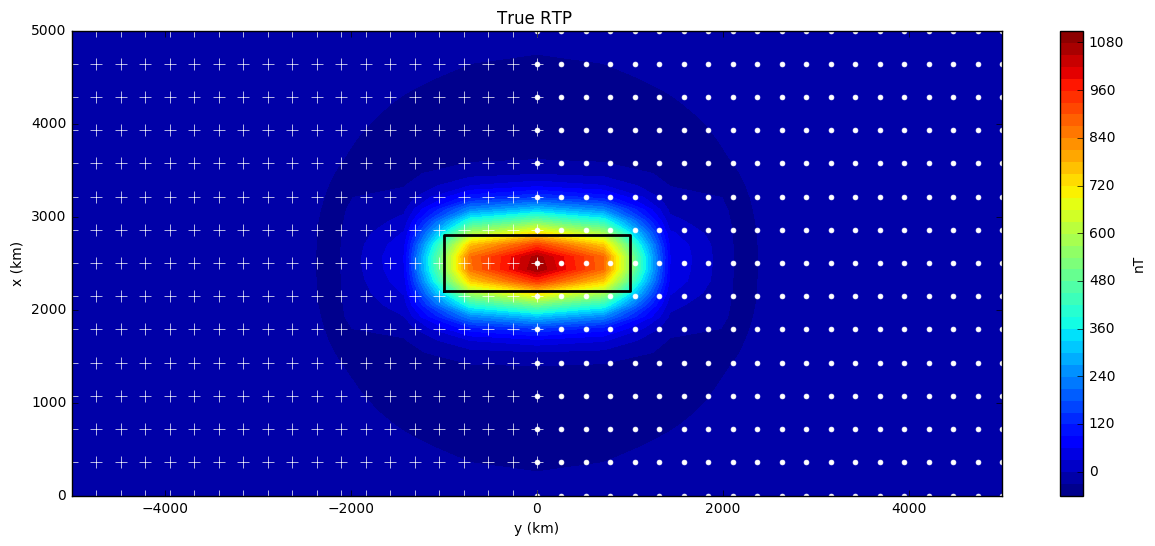

In [52]:
file_name = '..\\figs\\True_RTP'

plt.figure(figsize=(15, 6))
unit = 'nT'
mpl.contourf(yp, xp, tfpole, shape, 40, interp=True)

plt.plot(yp1, xp1, 'w+', markersize=9)
plt.plot(yp2, xp2, 'w.', markersize=7)
cbar = plt.colorbar()
cbar.set_label(unit)
ax = plt.gca()
for i, sq in enumerate(full_model_single_pole['projection_pole']):
    y1, y2, x1, x2 = sq
    xs_p = [x1, x1, x2, x2, x1]
    ys_p = [y1, y2, y2, y1, y1]
    projection_style = '-k'
    ax.plot(xs_p, ys_p, projection_style,linewidth = 2.0 )
ax.set_ylabel('x (km)')
ax.set_xlabel('y (km)')
ax.set_title('True RTP ')
plt.savefig(file_name+'.eps', dpi=600)

In [53]:
print 'Geomagnetic Filed used in the Equivalent Layer:', Inc_Geomag_EqLayer, Dec_Geomag_EqLayer
print 'Geomagnetic Field chosen was the magnetic survey: ', chosen_survey + 1

Geomagnetic Filed used in the Equivalent Layer: 60.0 10.0
Geomagnetic Field chosen was the magnetic survey:  2


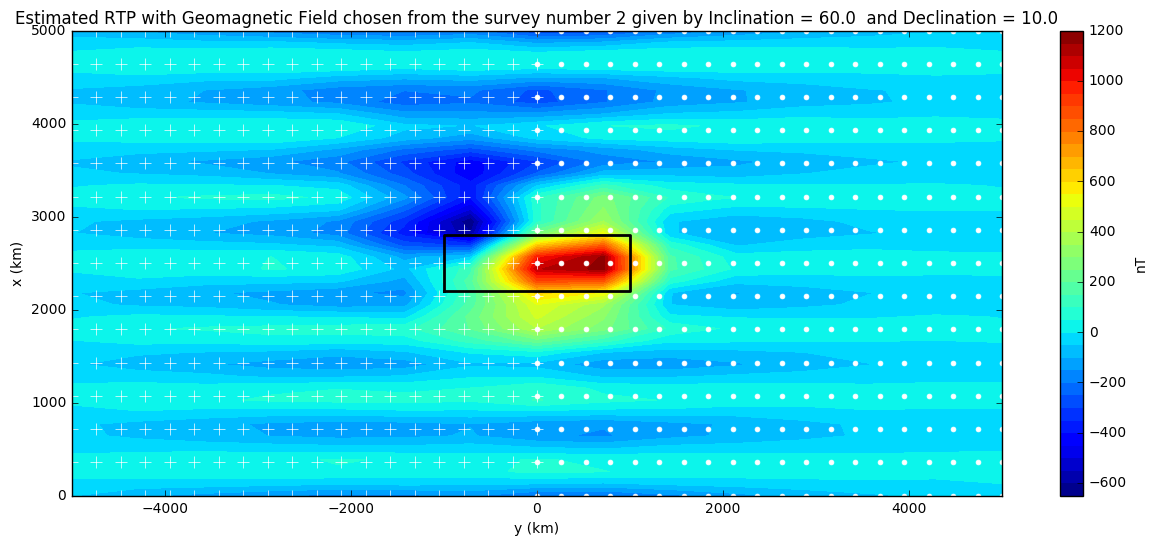

In [54]:
file_name = '..\\figs\\Estimated_RTP'

plt.figure(figsize=(15, 6))
unit = 'nT'
mpl.contourf(yp, xp, tfreduced, shape, 40, interp=True)

plt.plot(yp1, xp1, 'w+', markersize=9)
plt.plot(yp2, xp2, 'w.', markersize=7)
cbar = plt.colorbar()
cbar.set_label(unit)
ax = plt.gca()
for i, sq in enumerate(full_model_single['projection']):
    y1, y2, x1, x2 = sq
    xs = [x1, x1, x2, x2, x1]
    ys = [y1, y2, y2, y1, y1]
    projection_style = '-k'
    ax.plot(xs, ys, projection_style,linewidth = 2.0 )
ax.set_ylabel('x (km)')
ax.set_xlabel('y (km)')
ax.set_title('Estimated RTP with Geomagnetic Field chosen from the survey number %d given by Inclination = %.1f  and Declination = %.1f' % (chosen_survey + 1, Inc_Geomag_EqLayer, Dec_Geomag_EqLayer))
plt.savefig(file_name+'.eps', dpi=600)


In [55]:
assert (xs == xs_p) and (ys == ys_p), 'The synthetic model must be equal of the synthetic model in the pole '

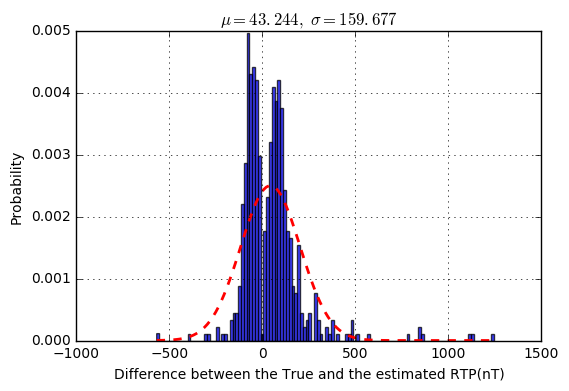

In [56]:
tf_diff = tfpole-tfreduced
(mu, sigma) = norm.fit(tf_diff)
# the histogram of the difference between the true and the estimated RTP
n_h, bins, patches = plt.hist(tf_diff, 120, normed=1, facecolor='blue', alpha=0.75)
# add a 'best fit' line
y_histogram = mlab.normpdf(bins, mu, sigma)
l_histogram = plt.plot(bins, y_histogram, 'r--', linewidth=2)
plt.xlabel('Difference between the True and the estimated RTP(nT)')
plt.ylabel('Probability')
plt.title(r'$ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)
#plt.show()
#mpl.savefig('res_histo_densi_estimada.png', pad_inches=0.0)
